# Fundamentals of Data Visualization
## Using geospatial Data 

sources:
* https://towardsdatascience.com/how-tracking-apps-analyse-your-gps-data-a-hands-on-tutorial-in-python-756d4db6715d
* https://github.com/andyakrn/activities_heatmap/blob/master/garmin_activities_proc.ipynb
* https://medium.com/@azholud/analysis-and-visualization-of-activities-from-garmin-connect-b3e021c62472




Inspiration:

https://towardsdatascience.com/loading-data-from-openstreetmap-with-python-and-the-overpass-api-513882a27fd0
https://tomcasavant.com/generating-heat-maps-from-gpx-files/
https://towardsdatascience.com/lets-make-a-map-using-geopandas-pandas-and-matplotlib-to-make-a-chloropleth-map-dddc31c1983d





In [4]:
import pandas as pd
import gpxpy
import matplotlib.pyplot as plt
import folium


In [2]:
# importing and parsing the gpx file 
gpx_file = open('data/Lunch_Run.gpx', 'r')
gpx = gpxpy.parse(gpx_file)

In [3]:
# check how the data is devided
len(gpx.tracks)
len(gpx.tracks[0].segments)
len(gpx.tracks[0].segments[0].points)

# everything is in points
data = gpx.tracks[0].segments[0].points

In [4]:
# add all information to a dataframe
df = pd.DataFrame(columns=['lon', 'lat', 'alt', 'time'])

for point in data:
    df = df.append({'lon': point.longitude, 'lat' : point.latitude, 'alt' : point.elevation, 'time' : point.time.strftime('%H:%M:%S')}, ignore_index=True)

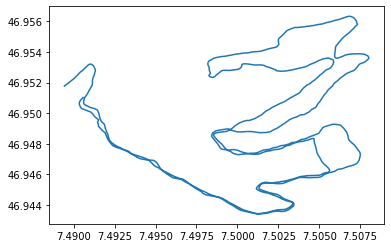

In [5]:
# simple lon/lat plot using matplotlib
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(df['lon'],df['lat'])

fig.savefig('1.png')


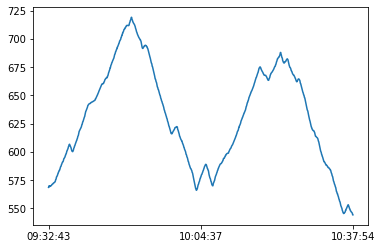

In [6]:
# elevation vs. time
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(df['time'],df['alt'])
ax.set_xticks([0,len(df['time'])/2,len(df['time'])-1])

fig.savefig('2.png')

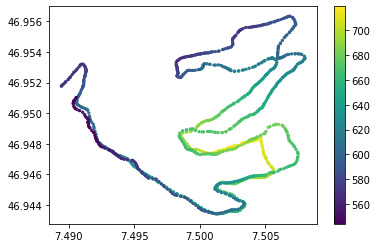

In [8]:
# map elevation on plot
plt.scatter(df['lon'],df['lat'],c=df['alt'],cmap='viridis',s=5)
plt.colorbar()
plt.savefig('3.png')

In [5]:
# Data preparation

#getting the average of lon/lat to get center of map
lon_a = df['lon'].mean()
lat_a = df['lat'].mean()
# adding lon/lat to tuples
points = list(zip(df['lat'],df['lon']))

In [89]:
m = folium.Map( location=[lat_a,lon_a], zoom_start=15)
folium.PolyLine(points, color="red", weight=2.5, opacity=1).add_to(m)

title_html =    '''
                <body style="background-color:#9dc6ea">
                <h3 align="center" style="font-size:20px"><b>{title}</b></h3>
                '''.format(title='Example title')
extra_html =    '''
                <div style="
                position: fixed; 
                top: 100px; left: 50px; width: 180px; height: 80px; 
                border:2px solid grey; z-index:9999; 
                padding:5px;
                
                background-color:white;
                opacity:0.8;
                
                font-size:14px;
                font-weight: bold;
            
                ">
                {title} 
                </div> '''.format( title = "Some more text explaining something important")
m.get_root().html.add_child(folium.Element(title_html))
m.get_root().html.add_child(folium.Element(extra_html))

m

In [88]:
# adding a icon to the map (fontawesome icon: https://fontawesome.com/v4.7.0/icons/)
map = folium.Map(location=[lat_a,lon_a], zoom_start=14, )
folium.PolyLine(points, color="red", weight=2.5, opacity=1).add_to(map)
#folium.Marker(
#    location=[points[0][0], points[0][1]],
#    popup="Start of the run",
#    icon=folium.Icon(color="green", icon="play", prefix='fa'),
#).add_to(map)
folium.Circle(
    [points[0][0], points[0][1]], 
    20, 
    fill=True
).add_to(map)
folium.Circle(
    [points[-1][0], points[-1][1]], 
    20, 
    fill=True,
    color='green'
).add_to(map)
map

In [87]:
map = folium.Map( location=[lat_a,lon_a], zoom_start=14, tiles='https://wmts.geo.admin.ch/1.0.0/ch.swisstopo.pixelkarte-farbe/default/current/3857/{z}/{x}/{y}.jpeg', attr='swisstopo')
folium.PolyLine(points, color="red", weight=2.5, opacity=1).add_to(map)

map

# Chapter 2

First step is to get an oauth token from strava.

1. Open this [this link](https://www.strava.com/oauth/authorize?client_id=42996&response_type=code&redirect_uri=http://localhost&approval_prompt=auto&scope=activity:read_all), 

2. read the oauth code from the redirected url http://localhost/token_exchange.php?state=&code=XXXX

Strava API docs :
http://strava.github.io/api/v3/oauth/

In [48]:
import requests
import polyline
import statistics
import numpy as np
import matplotlib.dates as mdates
from pandas import json_normalize

In [8]:
strava_oauth_code = "8ba3c31973abed826d6ea7138517a4798a1e6cf2"

In [9]:
payload = {
    'client_id':"42996",
    'client_secret':"847784a4a96fbb33fabe1f155dfa5a1e1d059e38",
    'code':strava_oauth_code,
    'grant_type':"authorization_code"
}
resp = requests.post("https://www.strava.com/oauth/token", params=payload)

assert resp.status_code == 200

access_token = resp.json()['access_token']
refresh_token = resp.json()['refresh_token']
headers = {
    'Authorization': "Bearer " + access_token
}

print(resp.status_code)

200


In [10]:
resp = requests.get("https://www.strava.com/api/v3/athlete", headers=headers)
assert resp.status_code == 200
athlete = resp.json()
print(athlete['firstname'], athlete['lastname'])

Lukas Reber


In [47]:
# getting all activities in a certain daterange
def get_activities(a,b):
    import datetime
    after = datetime.datetime.strptime(a, "%d.%m.%Y")
    after_timestamp = int(datetime.datetime.timestamp(after))

    before = datetime.datetime.strptime(b, "%d.%m.%Y")
    before_timestamp = int(datetime.datetime.timestamp(before))

    headers = {
        'accept': "application/json",
        'Authorization': "Bearer " + access_token
    }

    keepgoing = True
    activities = []
    page = 1
    while keepgoing:
        res = requests.get("https://www.strava.com/api/v3/athlete/activities?before={0}&after={1}&per_page=30&page={2}".format(before_timestamp,after_timestamp,page), headers=headers).json()
        if len(res) == 0:
            keepgoing = False
        page += 1
        activities.extend(res)

    # convert activities to dataframe
    df = json_normalize(activities)

    # convert datetime
    df['start_date_local'] = pd.to_datetime(df['start_date_local'])
    df['start_time'] = df['start_date_local'].dt.time
    df['start_date_local'] = df['start_date_local'].dt.date

    return df


    

In [12]:
act = get_activities("01.01.2020","01.07.2020")
print(len(act))

251


In [17]:
# try plotting the first activity on a map

track = polyline.decode(act.iloc[0]['map.summary_polyline'])

lat = [x for x,y in track]
lon = [y for x,y in track]

#getting the average of lon/lat to get center of map
lon_a = statistics.mean(lon)
lat_a = statistics.mean(lat)

map = folium.Map(location=[lat_a,lon_a], zoom_start=14, )
folium.PolyLine(track, color="red", weight=2.5, opacity=1).add_to(map)

map

In [18]:
#first filter the dataframe
df_runs = act.copy()
df_runs = df_runs[df_runs['type'] == 'Run']

# since the average_speed is meter/seconds which is not really relatable for runs, lets add another column which calculated min/km
df_runs['min_km'] = (df_runs['moving_time'] / 60) / (df_runs['distance'] / 1000)

In [19]:
# lets visualize all runs on a map
track = []

#getting the average of lon/lat to get center of map
lon_a = statistics.mean(lon)
lat_a = statistics.mean(lat)

map = folium.Map(location=[lat_a,lon_a], zoom_start=14, )

for index in range(len(df_runs)):
    track = polyline.decode(df_runs.iloc[index]['map.summary_polyline'])

    lat = [x for x,y in track]
    lon = [y for x,y in track]

    folium.PolyLine(track, color="red", weight=2.5, opacity=1).add_to(map)

map

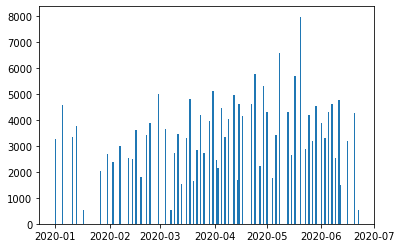

In [20]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.bar(df_runs['start_date_local'],df_runs['moving_time'])

plt.show()

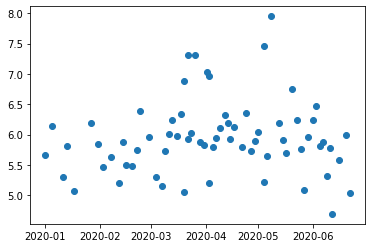

In [312]:
# visualize average speed over time

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot_date(df_runs['start_date_local'],df_runs['min_km'])

plt.show()

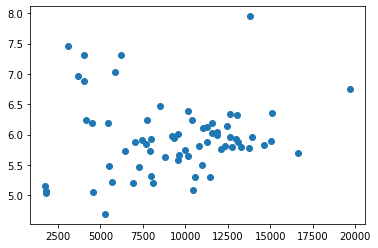

In [21]:
# visualize lenght vs average speed

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(df_runs['distance'],df_runs['min_km'])

plt.show()

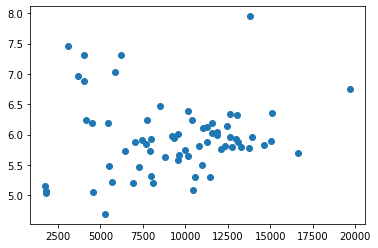

In [22]:
# visualize elevation vs average speed
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(df_runs['distance'],df_runs['min_km'])

plt.show()

In [43]:
# lets see what we get with commuter data
com = get_activities('01.01.2018','01.01.2021')

In [78]:
#first filter the dataframe
df_com = com.copy()
df_com = df_com[(df_com['commute'] == True) & (df_com['type'] == 'Ride')]

# since the average_speed is meter/seconds which is not really relatable for runs, lets add another column which calculated km/h
df_com['km_h'] = (df_com['distance'] / 1000) / (df_com['moving_time'] / 3600)

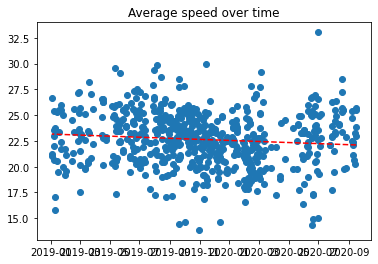

In [79]:
# visualize average speed over time
fig = plt.figure()

x = np.asarray(df_com['start_date_local'])
y = np.asarray(df_com['km_h'])

ax = fig.add_subplot(1,1,1)
ax.plot_date(df_com['start_date_local'],df_com['km_h'])
ax.set_title('Average speed over time')

#add trend line
x = mdates.date2num(x)
z=np.polyfit(x,y,1)
p=np.poly1d(z)
plt.plot(x,p(x),'r--')

plt.show()

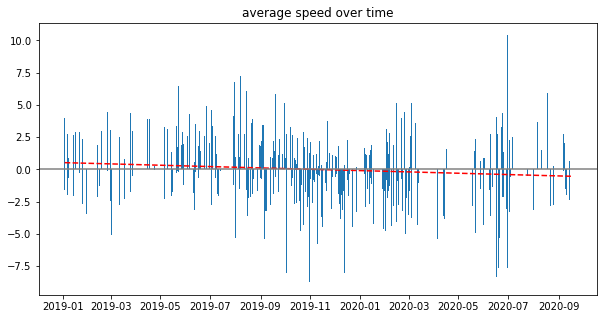

In [95]:
# lets see what it looks like if we substract the mean average speed

mean = df_com.km_h.mean()

x = np.asarray(df_com['start_date_local'])
y = np.asarray(df_com['km_h']-mean)

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.bar(df_com.start_date_local,df_com.km_h-mean)

#add trend line
x = mdates.date2num(x)
z=np.polyfit(x,y,1)
p=np.poly1d(z)
ax.plot(x,p(x),'r--')

# add horizontal line
ax.axhline(y=0,c='grey')

# add title
ax.set_title('average speed over time')

plt.show()

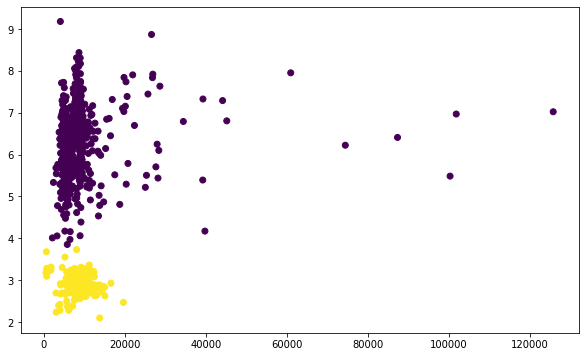

In [88]:

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.scatter(com.distance,com.average_speed,c=com.type.astype('category').cat.codes)


plt.show()

In [82]:
com.iloc[0]

resource_state                                                                   2
name                                                                 Afternoon Run
distance                                                                    5573.3
moving_time                                                                   1927
elapsed_time                                                                  1927
total_elevation_gain                                                          45.0
type                                                                           Run
workout_type                                                                   0.0
id                                                                      4516283005
external_id                                                 garmin_push_6001571433
upload_id                                                               4825455519
start_date                                                    2020-12-25T15:24:04Z
star